In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data.csv').replace('-', np.NaN).astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       2000 non-null   float64
 1   x       819 non-null    float64
 2   y       827 non-null    float64
dtypes: float64(3)
memory usage: 47.0 KB


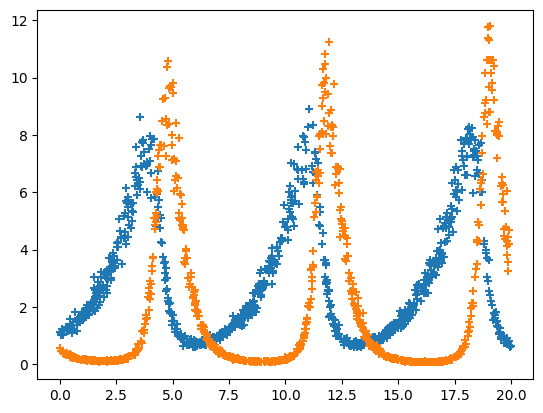

In [4]:
plt.scatter(x=df.t, y=df.x, marker='+')
plt.scatter(x=df.t, y=df.y, marker='+')
plt.show()

In [5]:
df_filled = df.interpolate(limit_direction='both')
df_filled

,t,x,y
0,0.00,1.115912,0.575905
1,0.01,1.115912,0.551311
2,0.02,1.115912,0.526716
3,0.03,1.060697,0.502121
4,0.04,1.005483,0.477527
...,...,...,...
1995,19.95,0.611707,4.186361
1996,19.96,0.615469,4.186361
1997,19.97,0.619231,4.186361
1998,19.98,0.622993,4.186361


<AxesSubplot:xlabel='t'>

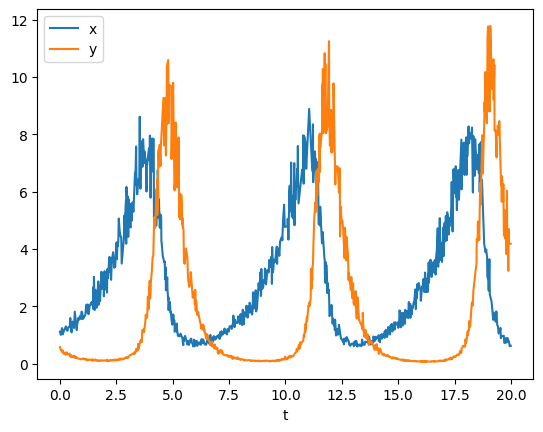

In [6]:
df_filled.plot(x='t', y=['x', 'y'])

In [130]:
class Net(nn.Module):
    '''Model to regress 2d time series values given scalar input.'''
    def __init__(self):
        super(Net, self).__init__()
        self.num_layers = 1
        self.hidden_units = 8
        
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=self.hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )
        
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=2)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [131]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file).replace('-', np.NaN).astype(float)
        self.df_filled = self.df.interpolate(limit_direction='both')
        self.X = torch.tensor(df_filled[['t']].values)
        self.y = torch.tensor(df_filled[['x', 'y']].values)
        self.seq_l = 5

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if idx >= self.seq_l:
            i_start = idx - self.seq_l
            X = self.X[i_start:idx]
        else:
            padding = self.X[0].repeat(self.seq_l - idx, 1)
            X = self.X[0:idx]
            X = torch.cat((padding, X), 0)

        return X.float(), self.y[idx].float()

In [107]:
train = TimeSeriesDataset('data.csv')
X, y = train[4]
X, y

(tensor([[0.0000],
         [0.0000],
         [0.0100],
         [0.0200],
         [0.0300]]),
 tensor([1.0055, 0.4775]))

In [108]:
df_filled.head(9)

,t,x,y
0,0.00,1.115912,0.575905
1,0.01,1.115912,0.551311
2,0.02,1.115912,0.526716
3,0.03,1.060697,0.502121
4,0.04,1.005483,0.477527
5,0.05,1.053657,0.468851
6,0.06,1.101832,0.460175
7,0.07,1.074546,0.465963
8,0.08,1.157007,0.471751


In [109]:
trainloader = torch.utils.data.DataLoader(train, batch_size=5, shuffle=True)

for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    print(inputs)
    print(inputs.shape)
    print(labels)
    print(labels.shape)
    break

tensor([[[17.1800],
         [17.1900],
         [17.2000],
         [17.2100],
         [17.2200]],

        [[15.3400],
         [15.3500],
         [15.3600],
         [15.3700],
         [15.3800]],

        [[ 8.1800],
         [ 8.1900],
         [ 8.2000],
         [ 8.2100],
         [ 8.2200]],

        [[ 2.6600],
         [ 2.6700],
         [ 2.6800],
         [ 2.6900],
         [ 2.7000]],

        [[ 9.4000],
         [ 9.4100],
         [ 9.4200],
         [ 9.4300],
         [ 9.4400]]])
torch.Size([5, 5, 1])
tensor([[4.9830, 0.1578],
        [1.8092, 0.0998],
        [1.7613, 0.1276],
        [4.4250, 0.1580],
        [3.2269, 0.0965]])
torch.Size([5, 2])


In [149]:
BATCH_SIZE = 10

dataset = TimeSeriesDataset('data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

# def loss_fn(outputs, labels):
#   #TODO

learning_rate = 0.01

loss_fn = nn.MSELoss()

net = Net()
# net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [150]:
for epoch in range(300):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 12.050
[1,    40] loss: 7.622
[1,    60] loss: 6.481
[1,    80] loss: 7.735
[1,   100] loss: 6.076
[1,   120] loss: 6.589
[1,   140] loss: 5.385
[1,   160] loss: 6.362
[1,   180] loss: 6.101
[1,   200] loss: 5.870
[2,    20] loss: 6.409
[2,    40] loss: 5.793
[2,    60] loss: 5.722
[2,    80] loss: 6.295
[2,   100] loss: 6.939
[2,   120] loss: 6.108
[2,   140] loss: 4.892
[2,   160] loss: 6.370
[2,   180] loss: 6.606
[2,   200] loss: 5.786
[3,    20] loss: 5.889
[3,    40] loss: 5.622
[3,    60] loss: 6.102
[3,    80] loss: 5.783
[3,   100] loss: 6.169
[3,   120] loss: 5.545
[3,   140] loss: 5.547
[3,   160] loss: 4.611
[3,   180] loss: 6.023
[3,   200] loss: 5.472
[4,    20] loss: 5.244
[4,    40] loss: 6.278
[4,    60] loss: 6.079
[4,    80] loss: 4.808
[4,   100] loss: 5.929
[4,   120] loss: 5.003
[4,   140] loss: 5.617
[4,   160] loss: 5.356
[4,   180] loss: 5.080
[4,   200] loss: 4.529
[5,    20] loss: 5.334
[5,    40] loss: 4.855
[5,    60] loss: 4.833
[5,    80]

In [151]:
# Plot results to validate training
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

predictloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False)

pred = predict(predictloader, net)
pred

tensor([[1.0045, 0.5495],
        [1.0045, 0.5495],
        [1.0099, 0.5438],
        ...,
        [1.6912, 7.9249],
        [1.6906, 7.9254],
        [1.6901, 7.9260]])

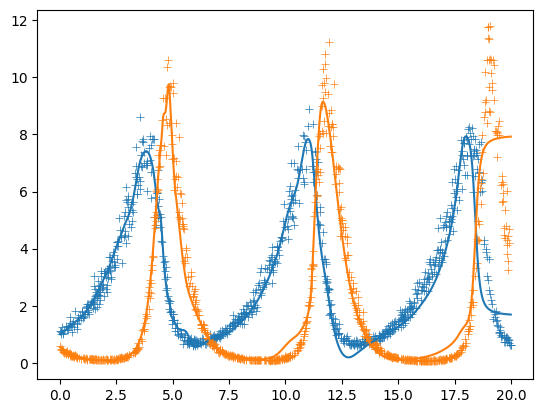

In [152]:
plt.scatter(x=df.t, y=df.x, marker='+', linewidths=.5)
plt.scatter(x=df.t, y=df.y, marker='+', linewidths=.5)
plt.plot(df.t, pred)
plt.show()